In [1]:
import os

In [2]:
%pwd

'/home/jafarid/code/yogaposes/research'

In [3]:
os.chdir('../')
%pwd

'/home/jafarid/code/yogaposes'

In [4]:
from dataclasses import dataclass
from pathlib import Path

In [5]:
@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path 
    resnet_trained_model_path: Path
    resnet_updated_base_model_path: Path
    traning_data: Path
    params_augmentation: bool
    params_image_size: list 
    params_batch_size: int 
    params_epoches: int
    params_learning_rate: float
    params_classes: int
    params_type: str
    all_params: dict
    mlflow_uri: str

In [6]:
from yogaposes.constants import *
from yogaposes.utils.common import read_yaml, create_directories
from dotenv import load_dotenv
load_dotenv()

MLFLOW_TRACKING_URI = os.environ['MLFLOW_TRACKING_URI']
MLFLOW_TRACKING_USERNAME = os.environ['MLFLOW_TRACKING_USERNAME']
MLFLOW_TRACKING_PASSWORD = os.environ['MLFLOW_TRACKING_PASSWORD']

In [7]:
class configurationManager:
    def __init__(self,config_file_path=CONFIG_FILE_PATH, params_file_path=PARAMS_FILE_PATH):
        self.config = read_yaml(config_file_path)
        self.params = read_yaml(params_file_path)
        
        create_directories([self.config.artifacts_root])
        
    def get_traning_config(self) -> TrainingConfig:
        model_training = self.config.model_training
        prepare_base_model = self.config.prepare_base_model
        training_data = os.path.join(self.config.data_ingestion.root_dir, 'yoga-poses-dataset')
        
        create_directories([model_training.root_dir])
        
        training_config = TrainingConfig(root_dir= model_training.resnet_trained_model_path, 
                                        resnet_trained_model_path= model_training.resnet_trained_model_path,
                                        resnet_updated_base_model_path= prepare_base_model.resnet_updated_base_model_path,
                                        traning_data = training_data,
                                        params_augmentation = self.params.AUGMENTATION,
                                        params_image_size = self.params.IMAGE_SIZE,
                                        params_classes = self.params.CLASSES,
                                        params_batch_size= self.params.BATCH_SIZE,
                                        params_epoches = self.params.EPOCHS,
                                        params_learning_rate = self.params.LEARNING_RATE,
                                        params_type = self.params.TYPE,
                                        all_params = self.params,
                                        mlflow_uri= MLFLOW_TRACKING_URI
                                        )
        
        return training_config

In [17]:
import torch
import torch.optim as optim
from torch import nn
from datasets import load_dataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop, ToPILImage
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import mlflow
from urllib.parse import urlparse
from PIL import ImageFile, Image
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTImageProcessor
from transformers import Trainer, TrainingArguments
from torchinfo import summary
import requests
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [9]:
# loading the dataset
ROOT = 'artifacts/data_ingestion/yoga-poses-dataset/DATASET/'
ImageFile.LOAD_TRUNCATED_IMAGES = True
dataset = load_dataset("imagefolder", data_files={"train": f"{ROOT}/TRAIN/**", "test": f"{ROOT}/TEST/**"}, drop_labels=False)

Generating train split: 1081 examples [00:00, 16150.15 examples/s]
Generating test split: 470 examples [00:00, 17308.40 examples/s]


In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1081
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 470
    })
})

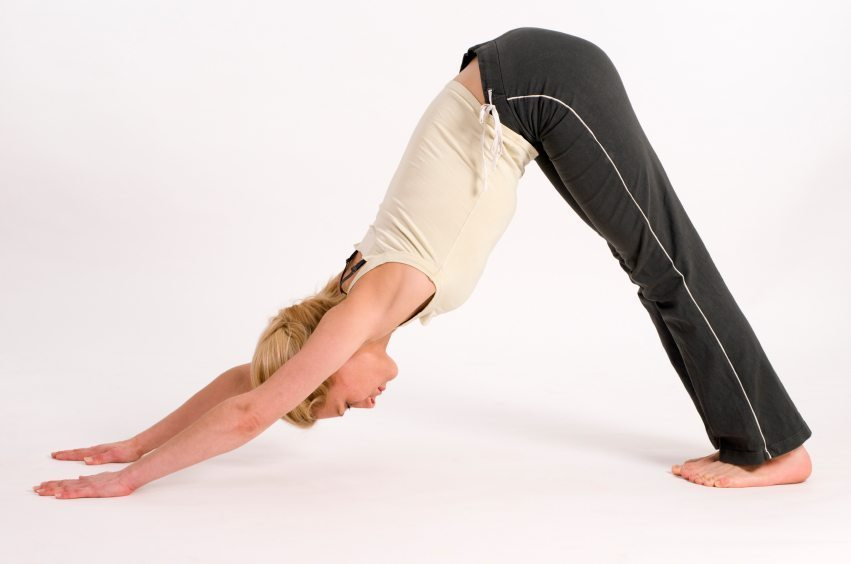

In [12]:
dataset['train'][0]['image']

In [10]:
# mapping of integer of labels to strings and vv
id2label = dict((k,v) for k,v in enumerate(dataset['train'].features['label'].names))
label2id = dict((v,k) for k,v in enumerate(dataset['train'].features['label'].names))
print(id2label)
print(label2id)

{0: 'downdog', 1: 'goddess', 2: 'plank', 3: 'tree', 4: 'warrior2'}
{'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}


In [13]:
# preporcesing and model selection 
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
mu, sigma = processor.image_mean, processor.image_std #get default mu,sigma
size = processor.size
norm = Normalize(mean=mu, std=sigma)  #normalize image pixels range to [-1,1]

_transformer = Compose([
    Resize((224, 224)), # Resize images to fit model input size
    ToTensor(), # Convert images to tensors
    norm
])

# apply transforms to PIL Image and store it to 'pixels' key
def preprocess(arg): 
    arg['pixel'] = [_transformer(image.convert('RGB')) for image in arg['image']]
    return arg 

dataset['train'].set_transform(preprocess)
dataset['test'].set_transform(preprocess)

In [15]:
dataset['test'][0]['pixel'].size()

torch.Size([3, 224, 224])

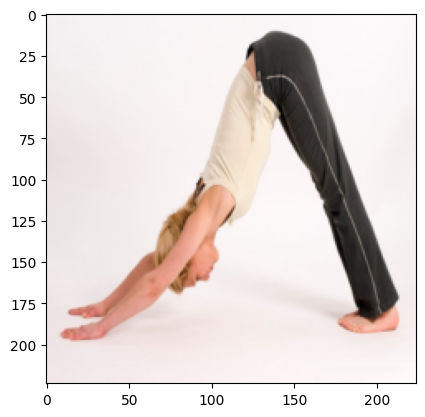

In [20]:
example = dataset['train'][0]['pixel']
example = (example+1)/2  #imshow requires image pixels to be in the range [0,1]
exi = ToPILImage()(example)
plt.imshow(exi)
plt.show()

In [21]:
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(id2label), ignore_mismatched_sizes=True)
print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=5, bias=True)


In [25]:
training_args = TrainingArguments(
    output_dir='./results',             # Output directory
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,                 # Total number of training epochs
    per_device_train_batch_size=8,      # Batch size per device during training
    per_device_eval_batch_size=4,       # Batch size for evaluation
    warmup_steps=500,                   # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                  # Strength of weight decay
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs',               # Directory for storing logs
    remove_unused_columns=False,
    logging_steps=10,
)

/home/jafarid/miniconda3/envs/yogaposes/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [26]:
training_args.report_to = []   # to avoid getting error from not setting up the ml flow 

In [32]:
def collate_fn(examples):
    pixels = torch.stack([example["pixel"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions,labels))

In [33]:
trainer = Trainer(
    model, 
    training_args, 
    train_dataset=dataset["train"], 
    eval_dataset=dataset["test"], 
    data_collator=collate_fn, 
    compute_metrics=compute_metrics,
    tokenizer=processor,
    )

In [34]:
trainer.train()

  0%|          | 0/408 [00:40<?, ?it/s]
                                                
  2%|▏         | 10/408 [00:13<09:06,  1.37s/it]

{'loss': 1.7759, 'grad_norm': 10.112339973449707, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.07}


                                                
  5%|▍         | 20/408 [00:27<09:08,  1.41s/it]

{'loss': 1.8214, 'grad_norm': 11.150064468383789, 'learning_rate': 8.000000000000001e-07, 'epoch': 0.15}


                                                
  7%|▋         | 30/408 [00:41<08:42,  1.38s/it]

{'loss': 1.7847, 'grad_norm': 12.334122657775879, 'learning_rate': 1.2000000000000002e-06, 'epoch': 0.22}


                                                
 10%|▉         | 40/408 [00:56<08:59,  1.46s/it]

{'loss': 1.8335, 'grad_norm': 11.439502716064453, 'learning_rate': 1.6000000000000001e-06, 'epoch': 0.29}


                                                
 12%|█▏        | 50/408 [01:10<08:29,  1.42s/it]

{'loss': 1.7813, 'grad_norm': 10.198282241821289, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.37}


 14%|█▎        | 56/408 [01:19<08:29,  1.45s/it]/home/jafarid/miniconda3/envs/yogaposes/lib/python3.8/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
                                                
 15%|█▍        | 60/408 [01:25<08:35,  1.48s/it]

{'loss': 1.7607, 'grad_norm': 11.145706176757812, 'learning_rate': 2.4000000000000003e-06, 'epoch': 0.44}


                                                
 17%|█▋        | 70/408 [01:40<08:14,  1.46s/it]

{'loss': 1.6772, 'grad_norm': 9.607093811035156, 'learning_rate': 2.8000000000000003e-06, 'epoch': 0.51}


                                                
 20%|█▉        | 80/408 [01:54<08:12,  1.50s/it]

{'loss': 1.5795, 'grad_norm': 11.35445785522461, 'learning_rate': 3.2000000000000003e-06, 'epoch': 0.59}


                                                
 22%|██▏       | 90/408 [02:09<07:48,  1.47s/it]

{'loss': 1.7155, 'grad_norm': 9.86972713470459, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.66}


                                                 
 25%|██▍       | 100/408 [02:24<07:54,  1.54s/it]

{'loss': 1.5777, 'grad_norm': 11.256125450134277, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.74}


                                                 
 27%|██▋       | 110/408 [02:40<07:38,  1.54s/it]

{'loss': 1.5225, 'grad_norm': 10.060590744018555, 'learning_rate': 4.4e-06, 'epoch': 0.81}


                                                 
 29%|██▉       | 120/408 [02:55<07:09,  1.49s/it]

{'loss': 1.4606, 'grad_norm': 14.84550952911377, 'learning_rate': 4.800000000000001e-06, 'epoch': 0.88}


                                                 
 32%|███▏      | 130/408 [03:09<06:54,  1.49s/it]

{'loss': 1.4209, 'grad_norm': 11.889182090759277, 'learning_rate': 5.2e-06, 'epoch': 0.96}


 33%|███▎      | 136/408 [03:17<05:19,  1.17s/it]





















































































































                                                 

                                           
 33%|███▎      | 136/408 [03:50<05:19,  1.17s/it]



{'eval_loss': 1.2981302738189697, 'eval_accuracy': 0.5340425531914894, 'eval_runtime': 32.1981, 'eval_samples_per_second': 14.597, 'eval_steps_per_second': 3.665, 'epoch': 1.0}


                                                 
 34%|███▍      | 140/408 [03:56<21:19,  4.78s/it]

{'loss': 1.3276, 'grad_norm': 8.989809036254883, 'learning_rate': 5.600000000000001e-06, 'epoch': 1.03}


                                                 
 37%|███▋      | 150/408 [04:11<06:41,  1.56s/it]

{'loss': 1.2497, 'grad_norm': 14.241308212280273, 'learning_rate': 6e-06, 'epoch': 1.1}


 37%|███▋      | 152/408 [04:14<06:25,  1.50s/it]/home/jafarid/miniconda3/envs/yogaposes/lib/python3.8/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
                                                 
 39%|███▉      | 160/408 [04:26<06:18,  1.53s/it]

{'loss': 1.1827, 'grad_norm': 8.16967487335205, 'learning_rate': 6.4000000000000006e-06, 'epoch': 1.18}


                                                 
 42%|████▏     | 170/408 [04:41<05:58,  1.51s/it]

{'loss': 1.1297, 'grad_norm': 10.258931159973145, 'learning_rate': 6.800000000000001e-06, 'epoch': 1.25}


                                                 
 44%|████▍     | 180/408 [04:56<05:35,  1.47s/it]

{'loss': 1.0654, 'grad_norm': 7.827882766723633, 'learning_rate': 7.2000000000000005e-06, 'epoch': 1.32}


                                                 
 47%|████▋     | 190/408 [05:11<05:32,  1.53s/it]

{'loss': 1.1146, 'grad_norm': 9.57231616973877, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.4}


                                                 
 49%|████▉     | 200/408 [05:26<05:10,  1.49s/it]

{'loss': 0.976, 'grad_norm': 8.707610130310059, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.47}


                                                 
 51%|█████▏    | 210/408 [05:41<04:47,  1.45s/it]

{'loss': 0.8224, 'grad_norm': 6.5156168937683105, 'learning_rate': 8.400000000000001e-06, 'epoch': 1.54}


                                                 
 54%|█████▍    | 220/408 [05:55<04:29,  1.43s/it]

{'loss': 0.7786, 'grad_norm': 8.471640586853027, 'learning_rate': 8.8e-06, 'epoch': 1.62}


                                                 
 56%|█████▋    | 230/408 [06:10<04:23,  1.48s/it]

{'loss': 0.8703, 'grad_norm': 7.703126907348633, 'learning_rate': 9.200000000000002e-06, 'epoch': 1.69}


                                                 
 59%|█████▉    | 240/408 [06:25<04:20,  1.55s/it]

{'loss': 0.7212, 'grad_norm': 5.696142196655273, 'learning_rate': 9.600000000000001e-06, 'epoch': 1.76}


                                                 
 61%|██████▏   | 250/408 [06:39<03:47,  1.44s/it]

{'loss': 0.6552, 'grad_norm': 5.178335189819336, 'learning_rate': 1e-05, 'epoch': 1.84}


                                                 
 64%|██████▎   | 260/408 [06:54<03:37,  1.47s/it]

{'loss': 0.4857, 'grad_norm': 5.813174247741699, 'learning_rate': 1.04e-05, 'epoch': 1.91}


                                                 
 66%|██████▌   | 270/408 [07:08<03:17,  1.43s/it]

{'loss': 0.5655, 'grad_norm': 7.445431709289551, 'learning_rate': 1.0800000000000002e-05, 'epoch': 1.99}


 67%|██████▋   | 272/408 [07:10<02:30,  1.10s/it]





















































































































                                                 
                                    

 67%|██████▋   | 272/408 [07:42<02:30,  1.10s/it]



{'eval_loss': 0.34623101353645325, 'eval_accuracy': 0.9340425531914893, 'eval_runtime': 31.8004, 'eval_samples_per_second': 14.78, 'eval_steps_per_second': 3.711, 'epoch': 2.0}


                                                 
 69%|██████▊   | 280/408 [07:54<04:57,  2.32s/it]

{'loss': 0.3397, 'grad_norm': 6.747213363647461, 'learning_rate': 1.1200000000000001e-05, 'epoch': 2.06}


                                                 
 71%|███████   | 290/408 [08:09<03:03,  1.55s/it]

{'loss': 0.2736, 'grad_norm': 4.894184112548828, 'learning_rate': 1.16e-05, 'epoch': 2.13}


                                                 
 74%|███████▎  | 300/408 [08:24<02:38,  1.47s/it]

{'loss': 0.3063, 'grad_norm': 3.6659374237060547, 'learning_rate': 1.2e-05, 'epoch': 2.21}


 75%|███████▌  | 307/408 [08:35<02:33,  1.52s/it]/home/jafarid/miniconda3/envs/yogaposes/lib/python3.8/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
                                                 
 76%|███████▌  | 310/408 [08:40<02:34,  1.58s/it]

{'loss': 0.2493, 'grad_norm': 4.059340000152588, 'learning_rate': 1.2400000000000002e-05, 'epoch': 2.28}


                                                 
 78%|███████▊  | 320/408 [08:55<02:16,  1.55s/it]

{'loss': 0.1699, 'grad_norm': 1.5178303718566895, 'learning_rate': 1.2800000000000001e-05, 'epoch': 2.35}


                                                 
 81%|████████  | 330/408 [09:10<01:59,  1.54s/it]

{'loss': 0.1745, 'grad_norm': 1.6743180751800537, 'learning_rate': 1.3200000000000002e-05, 'epoch': 2.43}


                                                 
 83%|████████▎ | 340/408 [09:25<01:38,  1.44s/it]

{'loss': 0.2673, 'grad_norm': 7.036490440368652, 'learning_rate': 1.3600000000000002e-05, 'epoch': 2.5}


                                                 
 86%|████████▌ | 350/408 [09:39<01:21,  1.41s/it]

{'loss': 0.2232, 'grad_norm': 8.406253814697266, 'learning_rate': 1.4e-05, 'epoch': 2.57}


                                                 
 88%|████████▊ | 360/408 [09:53<01:11,  1.48s/it]

{'loss': 0.1996, 'grad_norm': 0.8244516253471375, 'learning_rate': 1.4400000000000001e-05, 'epoch': 2.65}


                                                 
 91%|█████████ | 370/408 [10:07<00:53,  1.41s/it]

{'loss': 0.1529, 'grad_norm': 2.065791606903076, 'learning_rate': 1.48e-05, 'epoch': 2.72}


                                                 
 93%|█████████▎| 380/408 [10:22<00:39,  1.40s/it]

{'loss': 0.1191, 'grad_norm': 1.0583471059799194, 'learning_rate': 1.5200000000000002e-05, 'epoch': 2.79}


                                                 
 96%|█████████▌| 390/408 [10:36<00:25,  1.43s/it]

{'loss': 0.256, 'grad_norm': 6.642979621887207, 'learning_rate': 1.5600000000000003e-05, 'epoch': 2.87}


                                                 
 98%|█████████▊| 400/408 [10:50<00:11,  1.41s/it]

{'loss': 0.1143, 'grad_norm': 2.4851484298706055, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.94}


100%|██████████| 408/408 [11:00<00:00,  1.09s/it]





















































































































                                                 

                                           
100%|██████████| 408/408 [11:31<00:00,  1.09s/it]



{'eval_loss': 0.06999827176332474, 'eval_accuracy': 0.9808510638297873, 'eval_runtime': 30.7868, 'eval_samples_per_second': 15.266, 'eval_steps_per_second': 3.833, 'epoch': 3.0}


                                                 
100%|██████████| 408/408 [11:32<00:00,  1.70s/it]

{'train_runtime': 692.1033, 'train_samples_per_second': 4.686, 'train_steps_per_second': 0.59, 'train_loss': 0.9251528496251387, 'epoch': 3.0}


TrainOutput(global_step=408, training_loss=0.9251528496251387, metrics={'train_runtime': 692.1033, 'train_samples_per_second': 4.686, 'train_steps_per_second': 0.59, 'train_loss': 0.9251528496251387, 'epoch': 3.0})

In [35]:
trainer.save_model("artifacts/training/")

In [36]:
processor = ViTImageProcessor.from_pretrained("artifacts/training/")
model = ViTForImageClassification.from_pretrained("artifacts/training/")

In [37]:
outputs = trainer.predict(dataset["test"])
print(outputs.metrics)

100%|██████████| 118/118 [00:30<00:00,  3.91it/s]

{'test_loss': 0.06999827176332474, 'test_accuracy': 0.9808510638297873, 'test_runtime': 30.4702, 'test_samples_per_second': 15.425, 'test_steps_per_second': 3.873}


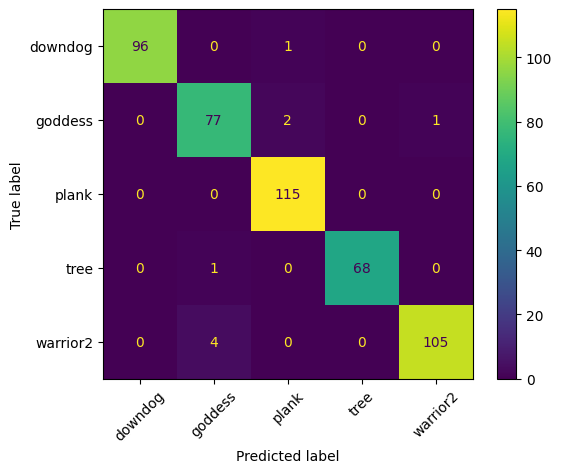

In [42]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = dataset["train"].features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [31]:
class TransformerModelTrainer(object):
    def __init__(self, config:TrainingConfig):
        self.config = config
        
        self.model, self.feature_extractor, self.processor = self.load_model()
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        
        self.train_loader, self.val_loader = self.set_loaders()
        
        
        
    def load_model(self):
        idTolabels = {0:'downdog', 1: 'godess', 2:'plank', 3:'tree', 4:'warrior2'}
        feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
        processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
        model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=self.config.params_classes,ignore_mismatched_sizes=True,id2label=idTolabels)
        
        return model, feature_extractor , processor
    
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def set_loaders(self):
        
        # Allow loading of truncated images
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        
        # image net statistics
        normalizer = Normalize(mean=self.feature_extractor.image_mean, std=self.feature_extractor.image_std)
        
        composer = Compose([Resize((224,224)), ToTensor(), normalizer])
        
        train_data = ImageFolder(root=os.path.join(self.config.traning_data,'DATASET/TRAIN'), transform=composer)
        val_data = ImageFolder(root=os.path.join(self.config.traning_data,'DATASET/TEST'), transform=composer)
        
        train_loader = DataLoader(train_data, batch_size=self.config.params_batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=self.config.params_batch_size)
        
        return train_loader, val_loader
    
    def collate_fn(self, examples):
        pixels = torch.stack([example["pixels"] for example in examples])
        labels = torch.tensor([example["label"] for example in examples])
        return {"pixel_values": pixels, "labels": labels}

    def compute_metrics(self, eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return dict(accuracy=accuracy_score(predictions, labels))
    
    def fine_tune(self, training_args):
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        
        # image net statistics
        normalizer = Normalize(mean=self.feature_extractor.image_mean, std=self.feature_extractor.image_std)
        
        composer = Compose([Resize((224,224)), ToTensor(), normalizer])
        train_data = ImageFolder(root=os.path.join(self.config.traning_data,'DATASET/TRAIN'), transform=composer)
        val_data = ImageFolder(root=os.path.join(self.config.traning_data,'DATASET/TEST'), transform=composer)
        trainer = Trainer(model=self.model,
                            args=training_args,
                            train_dataset=train_data,
                            eval_dataset=val_data,
                            #tokenizer=self.feature_extractor,
                            data_collator = self.set_loaders,
                            tokenizer = self.processor,
                        )
        trainer.train()
        

    def predict(self,x_filename):
        
        # Allow loading of truncated images
        ImageFile.LOAD_TRUNCATED_IMAGES = True       
        # Load an image
        image = Image.open(x_filename)
        encoding = self.feature_extractor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**encoding)

        # Extract the predicted class ID
        predicted_class_id = outputs.logits.argmax(-1).item()
       
        
        labels = {0:'downdog', 1: 'godess', 2:'plank', 3:'tree', 4:'warrior2'}
    
        
        return labels[predicted_class_id]
        

        

In [32]:
try:
    config = configurationManager()
    training_config = config.get_traning_config()
    training = TransformerModelTrainer(config=training_config)
    training.fine_tune(training_args)
    c = training.predict('artifacts/data_ingestion/yoga-poses-dataset/DATASET/TRAIN/plank/00000128.jpg')
    print(c)

except Exception as e:
    raise e

[2024-03-14 20:09:09,950: INFO: common: yaml file: config/config.yaml loaded successfully]
[2024-03-14 20:09:09,952: INFO: common: yaml file: params.yaml loaded successfully]
[2024-03-14 20:09:09,953: INFO: common: created directory at: artifacts]
[2024-03-14 20:09:09,953: INFO: common: created directory at: artifacts/training]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/408 [00:00<?, ?it/s]

TypeError: set_loaders() takes 1 positional argument but 2 were given

In [13]:
class ModelTrainer(object):
    def __init__(self, config:TrainingConfig, loss_fn=None, optimizer=None):
        self.config = config
        self.model = self.load_model()
        self.loss_fn = loss_fn if loss_fn else nn.CrossEntropyLoss(reduction='mean')
        self.optimizer = optimizer if optimizer else optim.Adam(self.model.parameters(), lr=self.config.params_learning_rate)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        
        self.train_loader, self.val_loader = self.set_loaders()
        
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        self.total_epoches = 0
        
        self.train_step_fn = self._make_train_step_fn()
        self.val_step_fn = self._make_val_step_fn()
        
    def load_model(self):
     
        return torch.load(self.config.resnet_updated_base_model_path)
    
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def set_loaders(self):
        
        # Allow loading of truncated images
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        
        # image net statistics
        normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
        
        composer = Compose([Resize(256), CenterCrop(224), ToTensor(), normalizer])
        
        train_data = ImageFolder(root=os.path.join(self.config.traning_data,'DATASET/TRAIN'), transform=composer)
        val_data = ImageFolder(root=os.path.join(self.config.traning_data,'DATASET/TEST'), transform=composer)
        
        train_loader = DataLoader(train_data, batch_size=self.config.params_batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=self.config.params_batch_size)
        
        return train_loader, val_loader
    
    # higher order function to be set and built globally and constructed the inner fuction without knowning x and y before hand
    def _make_train_step_fn(self):
        # single batch operation
        def perform_train_step_fn(x,y):
            # set the train mode
            self.model.train()
            
            # step 1: compute model output
            yhat = self.model(x)
            #yhat = yhat.float()
            #y = y.float()
            # step 2: compute the loss
              
            loss= self.loss_fn(yhat,y)
            
            # step 2': compute accuracy 
            yhat = torch.argmax(yhat,1)
            
            total_correct = (yhat ==y).sum().item()
            total = y.shape[0]
            acc = total_correct/total
            
            # step 3: compute the gradient
            loss.backward()
            
            #step4: update parameters
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            #step 5: return the loss
            return loss.item() , acc
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        # single batch operation
        def perform_val_step_fn(x,y):
            # set the model in val mode
            self.model.eval()
            
            #step 1: compute the prediction
            yhat = self.model(x)
            #yhat = yhat.float()
            #y = y.float()
            #step 2: compute the loss
            loss = self.loss_fn(yhat,y)
            # step 2': compute accuracy 
            yhat = torch.argmax(yhat,1)
          
            total_correct = (yhat ==y).sum().item()
            total = y.shape[0]
            acc = total_correct/total
            
            return loss.item(), acc
        return perform_val_step_fn
    
    def _mini_batch(self, validation=False):
        # one epoch operation 
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
            
        else: 
            data_loader = self.train_loader
            step_fn = self.train_step_fn
            
        if data_loader is None:
            return None
        
        mini_batch_losses = []
        mini_batch_accs = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            
            mini_batch_loss, mini_batch_acc = step_fn(x_batch,y_batch)
            
            mini_batch_losses.append(mini_batch_loss)
            mini_batch_accs.append(mini_batch_acc)
        
        loss = np.mean(mini_batch_losses)
        acc = np.mean(mini_batch_accs)
        return loss, acc
    
    def train(self, seed=42):
        self.set_seed(seed)
        
        for epoch in range(self.config.params_epoches):
            self.total_epoches +=1
            
            # perform training on mini batches within 1 epoch
            loss, acc = self._mini_batch(validation=False)
            self.losses.append(loss)
            self.accuracy.append(acc)
            # now calc validation
            with torch.no_grad():
                val_loss, val_acc = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
                self.val_accuracy.append(val_acc)
        
            print(f'\nEpoch: {epoch+1} \tTraining Loss: {loss:.4f} \tValidation Loss: {val_loss:.4f}')
            print(f'\t\tTraining Accuracy: {100 * acc:.2f}%\t Validation Accuracy: {100 * val_acc:.2f}%')
                
        self.save_checkpoint()
            
    def save_checkpoint(self):
        checkpoint = {'epoch': self.total_epoches,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'accuracy': self.accuracy,
                      'val_loss': self.val_losses,
                      'val_accuracy': self.val_accuracy
                      }
        torch.save(checkpoint, self.config.resnet_trained_model_path)
        
    def load_checkpoint(self):
        checkpoint = torch.load(self.config.resnet_trained_model_path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.total_epoches = checkpoint["epoch"]
        self.losses = checkpoint["loss"]
        self.accuracy = checkpoint['accuracy']
        self.val_accuracy = checkpoint['val_accuracy']
        self.val_losses = checkpoint["val_loss"]
        self.model.train() # always use train for resuming traning
        
    def _preprocess_image(self, filename):
        image = Image.open(filename)
        # Allow loading of truncated images
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        
        # image net statistics
        normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
        
        composer = Compose([Resize(256), CenterCrop(224), ToTensor(), normalizer])
        image = composer(image).unsqueeze(0)
        return image
        
    
    def predict(self,x_filename):
        
        self.load_checkpoint()
        self.model.eval()
        x = self._preprocess_image(x_filename)
        x_tensor = torch.as_tensor(x).float()
        y_hat_tensor = self.model(x_tensor.to(self.device))
        
        # set it back to the train mode
        self.model.train()
        
        labels = {0:'downdog', 1: 'godess', 2:'plank', 3:'tree', 4:'warrior2'}
        prediction=np.argmax(y_hat_tensor.detach().cpu().numpy())
        
        return labels[prediction]
    
    def log_into_mlflow(self):
        mlflow.set_registry_uri(self.config.mlflow_uri)
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        
        with mlflow.start_run():
            mlflow.log_params(self.config.all_params)
            mlflow.log_metrics({'train_loss': np.mean(self.losses),'val_loss': np.mean(self.val_losses), 'train_accuracy': np.mean(self.accuracy), 'val_accuracy': np.mean(self.val_accuracy)})
        
            # Model registry does not work with file store
            if tracking_url_type_store != "file":

                # Register the model
                # There are other ways to use the Model Registry, which depends on the use case,
                # please refer to the doc for more information:
                # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                mlflow.pytorch.log_model(self.model, "model", registered_model_name="ResNet18Model")
            else:
                mlflow.pytorch.log_model(self.model, "model")
        
            

In [49]:
try:
    config = configurationManager()
    training_config = config.get_traning_config()
    training = ModelTrainer(config=training_config)
    training.train()
    training.log_into_mlflow()

except Exception as e:
    raise e   

[2024-03-05 02:03:18,404: INFO: common: yaml file: config/config.yaml loaded successfully]
[2024-03-05 02:03:18,406: INFO: common: yaml file: params.yaml loaded successfully]
[2024-03-05 02:03:18,407: INFO: common: created directory at: artifacts]
[2024-03-05 02:03:18,407: INFO: common: created directory at: artifacts/training]


/home/jafarid/miniconda3/envs/yogaposes/lib/python3.8/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch: 1 	Training Loss: 8.5584 	Validation Loss: 4.1259
		Training Accuracy: 53.55%	 Validation Accuracy: 79.24%

Epoch: 2 	Training Loss: 3.5759 	Validation Loss: 1.1918
		Training Accuracy: 70.33%	 Validation Accuracy: 89.17%

Epoch: 3 	Training Loss: 2.8397 	Validation Loss: 4.4006
		Training Accuracy: 76.90%	 Validation Accuracy: 75.00%

Epoch: 4 	Training Loss: 2.3950 	Validation Loss: 1.7030
		Training Accuracy: 79.78%	 Validation Accuracy: 88.12%

Epoch: 5 	Training Loss: 2.6101 	Validation Loss: 1.0900
		Training Accuracy: 79.40%	 Validation Accuracy: 90.97%


Registered model 'ResNet18Model' already exists. Creating a new version of this model...
2024/03/05 02:06:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ResNet18Model, version 3
Created version '3' of model 'ResNet18Model'.


In [ ]:
try:
    config = configurationManager()
    training_config = config.get_traning_config()
    training = ModelTrainer(config=training_config, inference=True)
    training.train()
    training.log_into_mlflow()

except Exception as e:
    raise e   

In [15]:
try:
    config_inference = configurationManager()
    inference_config = config_inference.get_traning_config()
    inference = ModelTrainer(config=inference_config)
    c = inference.predict('artifacts/data_ingestion/yoga-poses-dataset/DATASET/TRAIN/plank/00000128.jpg')
    print(c)

except Exception as e:
    raise e   

[2024-03-05 19:20:36,074: INFO: common: yaml file: config/config.yaml loaded successfully]
[2024-03-05 19:20:36,076: INFO: common: yaml file: params.yaml loaded successfully]
[2024-03-05 19:20:36,077: INFO: common: created directory at: artifacts]
[2024-03-05 19:20:36,077: INFO: common: created directory at: artifacts/training]
plank
